# Visualisation des données dynamiques patient : supervision vs self-supervision
Ce notebook montre :

- Comment les trajectoires sont tronquées dans les tâches supervisées (`mortality24`, `los`, etc.)
- À quoi ressemble l'historique complet d'un patient
- Comment construire des fenêtres `[t-24, t]` pour un pré-entraînement SSL


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Choisir un task supervisé et charger les fichiers
task = "mortality24"
path = f"{task}/mimic_demo"

dyn = pd.read_parquet(f"{path}/dyn.parquet")
sta = pd.read_parquet(f"{path}/sta.parquet")
outc = pd.read_parquet(f"{path}/outc.parquet")

In [3]:
import pandas as pd
df = pd.read_parquet("base/mimic_iv_demo/dyn.parquet")
print(df.dtypes)
print(df.head(5))

stay_id              int32
time        timedelta64[s]
alb                float64
alp                float64
alt                float64
ast                float64
be                 float64
bicar              float64
bili               float64
bili_dir           float64
bnd                float64
bun                float64
ca                 float64
cai                float64
ck                 float64
ckmb               float64
cl                 float64
crea               float64
crp                float64
dbp                float64
fgn                float64
fio2               float64
glu                float64
hgb                float64
hr                 float64
inr_pt             float64
k                  float64
lact               float64
lymph              float64
map                float64
mch                float64
mchc               float64
mcv                float64
methb              float64
mg                 float64
na                 float64
neut               float64
o

In [7]:
print(dyn.columns)
print(sta.columns)
print(outc.columns)
print(dyn.shape)
print(sta.shape)
print(outc.shape)
# Afficher les 5 premières lignes de chaque DataFrame
print(dyn.head())
print(sta.head())
print(outc.head())
# Afficher les informations sur les DataFrames
print(dyn.info())
print(sta.info())
print(outc.info())
# Afficher les statistiques descriptives
print(dyn.describe())   


Index(['stay_id', 'time', 'alb', 'alp', 'alt', 'ast', 'be', 'bicar', 'bili',
       'bili_dir', 'bnd', 'bun', 'ca', 'cai', 'ck', 'ckmb', 'cl', 'crea',
       'crp', 'dbp', 'fgn', 'fio2', 'glu', 'hgb', 'hr', 'inr_pt', 'k', 'lact',
       'lymph', 'map', 'mch', 'mchc', 'mcv', 'methb', 'mg', 'na', 'neut',
       'o2sat', 'pco2', 'ph', 'phos', 'plt', 'po2', 'ptt', 'resp', 'sbp',
       'temp', 'tnt', 'urine', 'wbc'],
      dtype='object')
Index(['stay_id', 'age', 'sex', 'height', 'weight'], dtype='object')
Index(['stay_id', 'label'], dtype='object')
(2475, 50)
(99, 5)
(99, 2)
   stay_id            time  alb  alp  alt  ast   be  bicar  bili  bili_dir  \
0   201006 0 days 00:00:00  2.4  NaN  NaN  NaN  0.0   22.0   NaN       NaN   
1   201006 0 days 01:00:00  NaN  NaN  NaN  NaN  NaN    NaN   NaN       NaN   
2   201006 0 days 02:00:00  NaN  NaN  NaN  NaN  NaN    NaN   NaN       NaN   
3   201006 0 days 03:00:00  NaN  NaN  NaN  NaN  NaN    NaN   NaN       NaN   
4   201006 0 days 04:00:00  NaN

Patient sélectionné : 201006
Nombre d'heures disponibles : 25


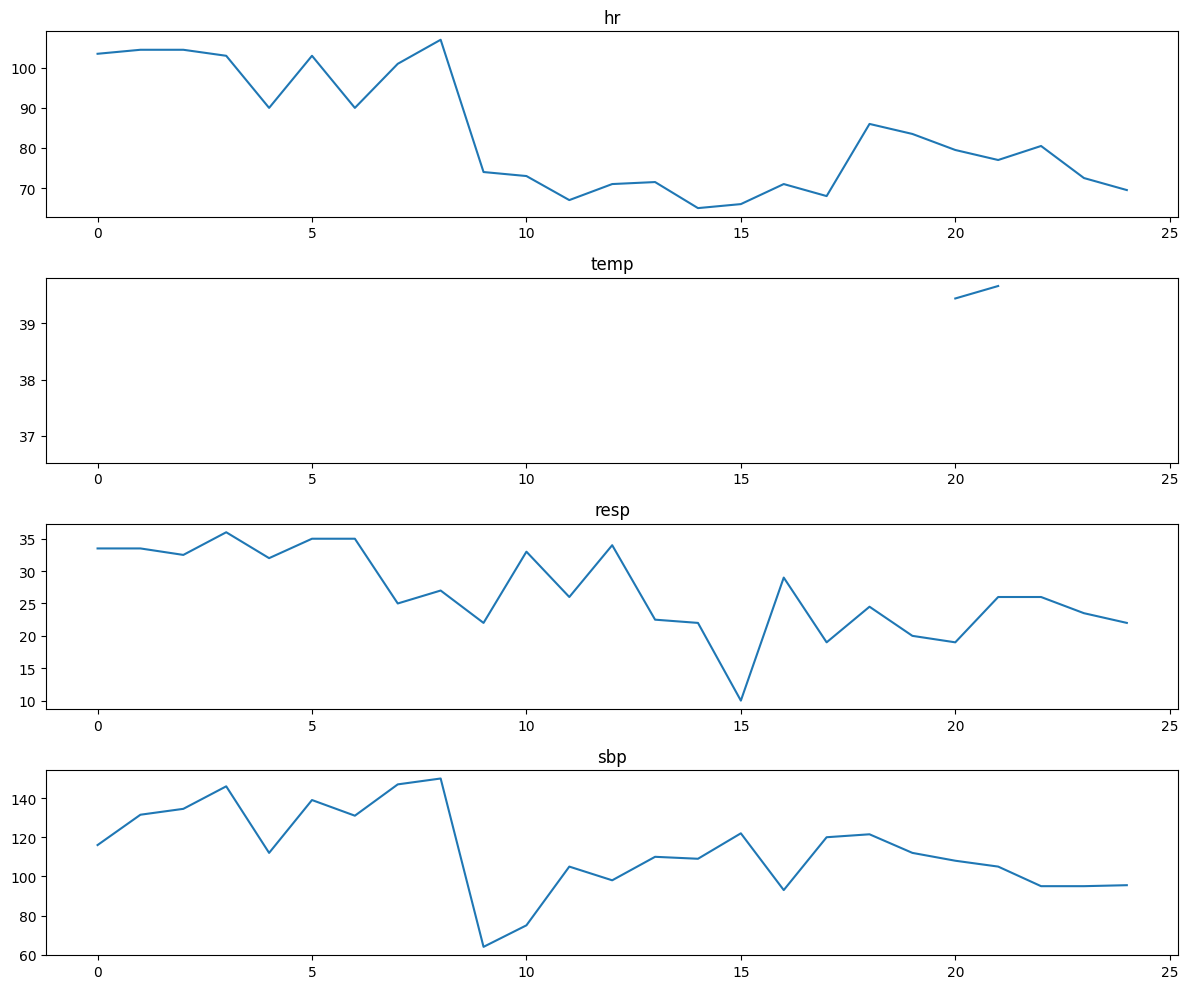

In [8]:
# Nouvelle colonne patient : on utilise 'stay_id'
patient_col = 'stay_id'
dyn['hour'] = dyn['time'].dt.components['hours'] + dyn['time'].dt.components['days'] * 24

# Choisir un patient
patient_id = dyn[patient_col].unique()[0]
patient_dyn = dyn[dyn[patient_col] == patient_id].sort_values('hour')

print(f"Patient sélectionné : {patient_id}")
print(f"Nombre d'heures disponibles : {len(patient_dyn)}")

# Afficher quelques features dynamiques
variables = ['hr', 'temp', 'resp', 'sbp']

fig, axs = plt.subplots(len(variables), 1, figsize=(12, 2.5 * len(variables)))
for i, var in enumerate(variables):
    axs[i].plot(patient_dyn['hour'], patient_dyn[var])
    axs[i].set_title(var)
plt.tight_layout()
plt.show()


In [14]:
import glob, pandas as pd, numpy as np

tasks = ["mortality24", "los", "aki", "kidney_function", "base", "sepsis"]
stats = []

for task in tasks:
    path = f"{task}/mimic_iv_demo/dyn.parquet"
    df   = pd.read_parquet(path)
    df["hour"] = df["time"].dt.components['hours'] + df["time"].dt.components['days']*24
    lengths = df.groupby("stay_id")["hour"].max() + 1          # +1 car on part de 0
    stats.append({
        "task": task,
        "n_stays": lengths.shape[0],
        "min_h": int(lengths.min()),
        "median_h": int(lengths.median()),
        "max_h": int(lengths.max())
    })

pd.DataFrame(stats)

,task,n_stays,min_h,median_h,max_h
0,mortality24,99,25,25,25
1,los,132,13,51,169
2,aki,113,13,32,169
3,kidney_function,69,25,25,25
4,base,132,13,51,169
5,sepsis,114,13,48,169


In [9]:
window_length = 24
ssl_windows = []

# Parcours de t = window_length à max(hour)
max_t = int(patient_dyn['hour'].max())

for t in range(window_length, max_t + 1):
    window = patient_dyn[(patient_dyn['hour'] > t - window_length) & (patient_dyn['hour'] <= t)]
    if len(window) == window_length:
        ssl_windows.append(window)

print(f"{len(ssl_windows)} fenêtres SSL de 24h générées pour le patient {patient_id}")


1 fenêtres SSL de 24h générées pour le patient 201006


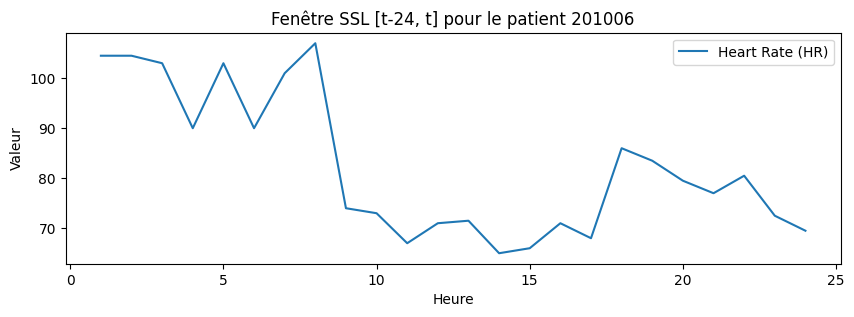

In [10]:
if ssl_windows:
    window = ssl_windows[0]  # première (et unique ici)

    plt.figure(figsize=(10, 3))
    plt.plot(window['hour'], window['hr'], label='Heart Rate (HR)')
    plt.xlabel("Heure")
    plt.ylabel("Valeur")
    plt.title("Fenêtre SSL [t-24, t] pour le patient 201006")
    plt.legend()
    plt.show()
else:
    print("Aucune fenêtre complète de 24h disponible pour ce patient.")
